![](pics/header.jpg)

# Aruco Marker and Apriltag Detection

Kevin Walchko

1 June 2022

---

## References

- github: [ArUCo-Markers-Pose-Estimation-Generation-Python](https://github.com/GSNCodes/ArUCo-Markers-Pose-Estimation-Generation-Python)

In [215]:
import numpy as np
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt
from math import atan2, asin, pi
from pathlib import Path

np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

def scale(im, s=1.0):
    (h,w) = im.shape
    return cv2.resize(im, (s*h, s*w,), interpolation=cv2.INTER_AREA)

## Generating Markers

```python
cv2.aruco.DICT_4X4_100 = 1
cv2.aruco.DICT_4X4_1000 = 3
cv2.aruco.DICT_4X4_250 = 2
cv2.aruco.DICT_4X4_50 = 0
cv2.aruco.DICT_5X5_100 = 5
cv2.aruco.DICT_5X5_1000 = 7
cv2.aruco.DICT_5X5_250 = 6
cv2.aruco.DICT_5X5_50 = 4
cv2.aruco.DICT_6X6_100 = 9
cv2.aruco.DICT_6X6_1000 = 11
cv2.aruco.DICT_6X6_250 = 10
cv2.aruco.DICT_6X6_50 = 8
cv2.aruco.DICT_7X7_100 = 13
cv2.aruco.DICT_7X7_1000 = 15
cv2.aruco.DICT_7X7_250 = 14
cv2.aruco.DICT_7X7_50 = 12
cv2.aruco.DICT_APRILTAG_16H5 = 17
cv2.aruco.DICT_APRILTAG_25h9 = 18
cv2.aruco.DICT_APRILTAG_36H10 = 19
cv2.aruco.DICT_APRILTAG_36H11 = 20
cv2.aruco.DICT_ARUCO_ORIGINAL = 16
    
img = cv2.aruco.drawMarker(dictionary, id, sidePixels[, img[, borderBits]])
```

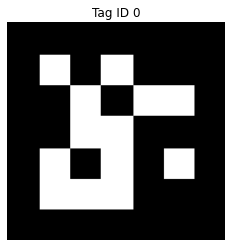

In [214]:
tagID = 0
tag_size = 100
borderBits = 1 # optional

tag = cv2.aruco.drawMarker(
    aruco.Dictionary_get(aruco.DICT_5X5_100),
    tagID,
    tag_size,
    borderBits=borderBits
)

tag = scale(tag, 4)

# cv2.imwrite(f"tags/aruco-{tagID}.png", tag)

plt.imshow(tag, cmap="gray")
plt.axis("off")
plt.title(f"Tag ID {tagID}");

## Detect Markers

```python
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, dictionary[, corners[, ids[, parameters[, rejectedImgPoints[, cameraMatrix[, distCoeff]]]]]])

image = cv2.aruco.drawDetectedMarkers(image, corners[, ids[, borderColor]])
```

In [199]:
def drawDetectedMarkers(image, corners, ids, size=1, color=None):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
    if len(corners) > 0:
        # cv2.aruco.drawDetectedMarkers(image, corners)
        
        # flatten the ArUco IDs list
        ids = ids.flatten()
        # loop over the detected ArUCo corners
        for (markerCorner, markerID) in zip(corners, ids):
            # extract the marker corners (which are always returned in
            # top-left, top-right, bottom-right, and bottom-left order)
            corners = markerCorner.reshape((4, 2))
            (topLeft, topRight, bottomRight, bottomLeft) = corners
            # convert each of the (x, y)-coordinate pairs to integers
            topRight = (int(topRight[0]), int(topRight[1]))
            bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
            bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
            topLeft = (int(topLeft[0]), int(topLeft[1]))
            
            thick = abs(topLeft[0] - bottomRight[0])//30
            cv2.line(image, topLeft, topRight, (0, 255, 0), thick)
            cv2.line(image, topRight, bottomRight, (0, 255, 0), thick)
            cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), thick)
            cv2.line(image, bottomLeft, topLeft, (0, 255, 0), thick)
            # compute and draw the center (x, y)-coordinates of the ArUco
            # marker
            dia = abs(topLeft[0] - bottomRight[0])//20
            cX = int((topLeft[0] + bottomRight[0]) / 2.0)
            cY = int((topLeft[1] + bottomRight[1]) / 2.0)
            cv2.circle(image, (cX, cY), dia, (255, 0, 255), -1)
            
            a = (topLeft[0]+dia,topLeft[1]+dia)
            b = (topLeft[0]-dia,topLeft[1]-dia)
            cv2.rectangle(image, a,b, (0, 0, 200), thick)
            
            # draw the ArUco marker ID on the image
            if color is None:
                color = (100, 100, 100)
            cv2.putText(
                image, str(markerID),
                (topLeft[0] + 2*dia, topLeft[1] - 2*dia), 
                cv2.FONT_HERSHEY_SIMPLEX,
                size, color, size)
            # print("[Inference] ArUco marker ID: {}".format(markerID))
    return image

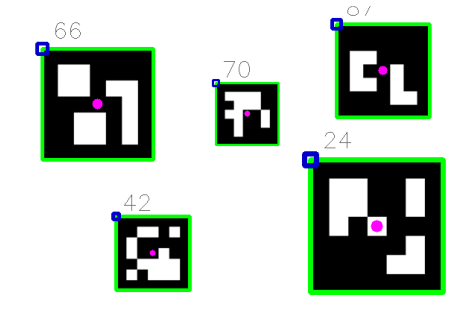

In [200]:
gray = cv2.imread("pics/2.png", 0)

corners, ids, rejectedImgPts = aruco.detectMarkers(
    gray, 
    aruco.Dictionary_get(aruco.DICT_5X5_100)
)

# print(ids)

# img = aruco_display(corners, ids, rejectedImgPts, gray)
# image = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
# cv2.aruco.drawDetectedMarkers(image, corners) 
image = drawDetectedMarkers(gray, corners, ids) 

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis("off");

## Estimate Pose

```python
rvecs, tvecs, _objPoints = cv2.aruco.estimatePoseSingleMarkers(corners, markerLength, cameraMatrix, distCoeffs[, rvecs[, tvecs[, _objPoints]]])

image = cv2.aruco.drawAxis(image, cameraMatrix, distCoeffs, rvec, tvec, length)
```

[66] ------------------------------
  RPY: -165.1, -48.8, -98.9 degrees
  T: [-0.   0.   0.1]
[42] ------------------------------
  RPY: 173.9, -46.1, -85.6 degrees
  T: [0.  0.  0.1]
[70] ------------------------------
  RPY: -170.1, -42.0, -96.4 degrees
  T: [-0.  -0.   0.1]
[87] ------------------------------
  RPY: -171.9, -36.5, -96.3 degrees
  T: [-0.  -0.   0.1]
[24] ------------------------------
  RPY: -179.2, -36.5, -90.2 degrees
  T: [ 0.  -0.   0.1]


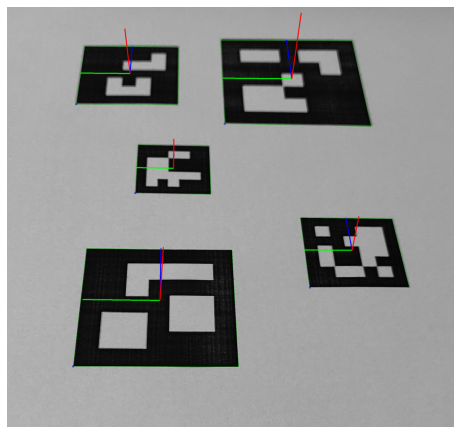

In [201]:
pose = cv2.imread("pics/pose.jpg", 0)
frame = cv2.cvtColor(pose, cv2.COLOR_GRAY2RGB)

h,w = pose.shape[:2]
f = max(h,w)  # focal length is a function of image size in pixels
K = np.array([
    [f,0,w/2],
    [0,f,h/2],
    [0,0,1]
])
dist = np.array([[0.0,0,0,0,0]])

corners, ids, rejectedImgPts = aruco.detectMarkers(
    pose,
    aruco.Dictionary_get(aruco.DICT_5X5_100), 
    parameters=aruco.DetectorParameters_create(),
    cameraMatrix=K,
    distCoeff=dist
)

if len(corners) > 0:
    cv2.aruco.drawDetectedMarkers(frame, corners) 
    for i in range(0, len(ids)):
        rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(
            corners[i], 
            0.02, 
            K,
            dist)
        
        R = cv2.Rodrigues(rvec)[0]
        t = tvec.ravel()
        print(ids[i], "-"*30)
        roll = atan2(R[2,1], R[2,2])*180/pi
        pitch = -asin(R[2,0])*180/pi
        yaw = atan2(R[1,0], R[0,0])*180/pi
        print(f"  RPY: {roll:0.1f}, {pitch:0.1f}, {yaw: 0.1f} degrees")
        print(f"  T: {t}")
        
        cv2.aruco.drawDetectedMarkers(frame, corners) 
        cv2.aruco.drawAxis(frame, K, dist, rvec, tvec, 0.01)
        # cv2.drawFrameAxes(frame, K, dist, rvec, tvec, length=0.01, thickness=20) 
        
    plt.figure(figsize=(8,8))
    plt.imshow(frame)
    plt.axis("off");

## AprilTags

They seem to work with Apriltags too!

[[6]
 [8]
 [7]
 [3]
 [2]
 [1]
 [0]
 [5]]


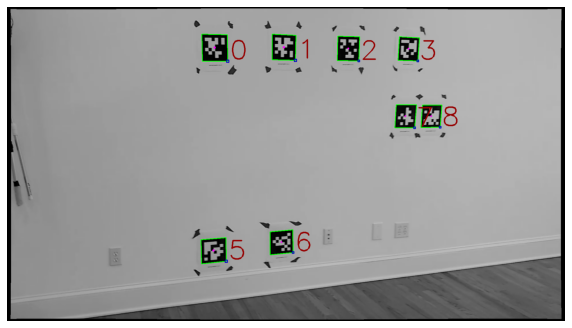

In [202]:
# apr = cv2.imread("pics/tag36_11.png", 0)
# apr = scale(apr, 100)
apr = cv2.imread("pics/apriltags.png", 0)

corners, ids, rejectedImgPts = aruco.detectMarkers(
    apr,
    aruco.Dictionary_get(aruco.DICT_APRILTAG_36h11), 
    # parameters=aruco.DetectorParameters_create()
)

print(ids)

apr = drawDetectedMarkers(apr, corners, ids, size=3, color=(150,0,0))

plt.figure(figsize=(10,10))
plt.imshow(apr, cmap="gray")
plt.axis("off");

## Comparing Aruco Tags and Apriltags

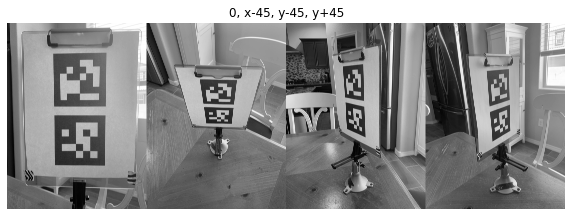

In [283]:
pose = []
fnames = Path("pose").glob("*.png")
for f in sorted(fnames):
    img = cv2.imread(str(f),0)
    pose.append(img)

plt.figure(figsize=(10,5))
plt.imshow(np.hstack(pose), cmap="gray")
plt.axis("off")
plt.title("0, x-45, y-45, y+45");

In [290]:
def findMarkers(imgs, flag):
    if not isinstance(imgs, list):
        imgs = [imgs]
        
    h,w = imgs[0].shape[:2]
    f = max(h,w)  # focal length is a function of image size in pixels
    K = np.array([
        [f,0,w/2],
        [0,f,h/2],
        [0,0,1]
    ])
    dist = np.array([[0.0,0,0,0,0]])
    
    pose = {} #{frame: {id: rpy}}
    rframes = []

    for num, gray in enumerate(imgs):
        if len(gray.shape) != 2:
            gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
            
        corners, ids, rejectedImgPts = aruco.detectMarkers(
            gray,
            aruco.Dictionary_get(flag), 
            parameters=aruco.DetectorParameters_create(),
            cameraMatrix=K,
            distCoeff=dist
        )
        
        frame = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

        if len(corners) > 0:
            ids = ids.ravel()
            drawDetectedMarkers(frame, corners,ids) 
            for i, id in enumerate(ids):
                rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(
                    corners[i],
                    0.02,
                    K,
                    dist)

                R = cv2.Rodrigues(rvec)[0]
                t = tvec.ravel()
                # print(ids[i], "-"*30)
                roll = atan2(R[2,1], R[2,2])*180/pi
                pitch = -asin(R[2,0])*180/pi
                yaw = atan2(R[1,0], R[0,0])*180/pi
                # print(f"  RPY: {roll:0.1f}, {pitch:0.1f}, {yaw: 0.1f} degrees")
                # print(f"  T: {t}")

                # cv2.aruco.drawDetectedMarkers(frame, corners) 
                # cv2.aruco.drawAxis(frame, K, dist, rvec, tvec, 0.01)
                cv2.drawFrameAxes(frame, K, dist, rvec, tvec, length=0.01, thickness=20)
                # print(id,roll, pitch, yaw)
                pose[num] = {id: (roll, pitch, yaw,)}
        rframes.append(frame)

    return pose, rframes

Frame[0]
  3: (-173.16475291097467, 3.8836735410767784, 0.21191024883092807)
Frame[1]
  3: (-128.20169244744966, 2.894927959651282, 1.6859202506213755)
Frame[2]
  3: (-157.70034234439174, 51.62509925614893, 15.199964926840027)
Frame[3]
  3: (-157.04115522901236, -46.027776906907924, -20.60638808863292)


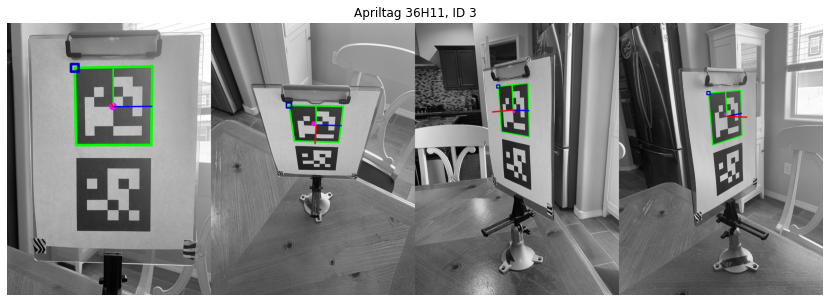

In [298]:
rpys, rframes = findMarkers(pose, aruco.DICT_APRILTAG_36h11)

for frame, idrpy in rpys.items():
    print(f"Frame[{frame}]")
    for id, rpy in idrpy.items():
        print(f"  {id}: {rpy}")
        
plt.figure(figsize=(15,5))
plt.imshow(np.hstack(rframes))
plt.axis("off")
plt.title("Apriltag 36H11, ID 3");

Frame[0]
  0: (175.88615822467088, -1.6881716703278293, -179.91512576001278)
Frame[1]
  0: (125.64606513527993, -2.4445450895872174, -178.62377130923613)
Frame[2]
  0: (153.2673376347259, -49.357577349890825, -161.93941175194726)
Frame[3]
  0: (153.04295166810275, 44.612065266554445, 156.63350136522598)


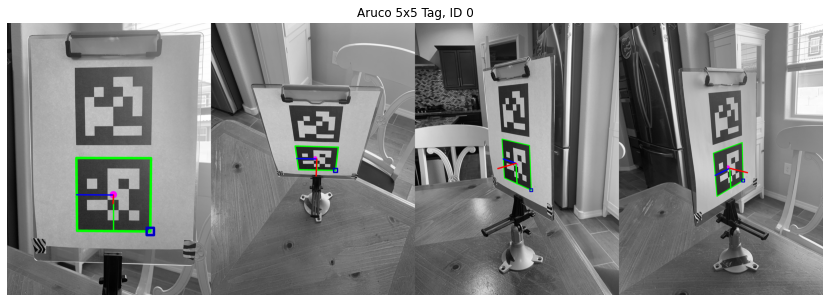

In [296]:
rpys, rframes = findMarkers(pose, aruco.DICT_5X5_100)

for frame, idrpy in rpys.items():
    print(f"Frame[{frame}]")
    for id, rpy in idrpy.items():
        print(f"  {id}: {rpy}")
        
plt.figure(figsize=(15,5))
plt.imshow(np.hstack(rframes))
plt.axis("off")
plt.title("Aruco 5x5 Tag, ID 0");